### 1. Import delle librerie necessarie

In [ ]:
import os
import sys
import librosa
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical, plot_model
from keras.models import Model, load_model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Input

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 

from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/My Drive/DSIM Project/processing1D/'
data_path = PATH + 'recordings/'
dump_path = PATH + 'dumps/'



Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Funzioni ausiliarie per il preprocessing

Di seguito vengono definite alcune funzioni per il preprocessing dei dati, prima di poter essere passati alla rete neurale.

- **printProgressBar** serve semplicemente per stampare la barra di avanzamento per il caricamento dei dati in memoria

In [ ]:
def printProgressBar(i,max,postText):
    n_bar =10 #size of progress bar
    j= i/max
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()

- **crop** serve per eliminare eventuali valori oppure per aggiungere zeri nell'estrazione della feature *mfcc*, in modo che tutti i dati abbiano la stessa dimensione

In [ ]:
def crop(input, size):
    # Elimina eventuali valori oltre il numero consentito
    output = input[0:min(size, input.shape[0])]
    # Aggiungi valori nulli per raggiungere la dimensione richiesta
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

- **wav2mfcc** estrae dagli audio di input la *mfcc*

In [ ]:
def wav2mfcc(file_path, max_len=40):
  seconds=3
  wave, sr = librosa.load(file_path, mono=True, sr=44100)
  #wave = wave[::3]
  wave = crop(wave, sr*seconds)
  mfcc = librosa.feature.mfcc(wave, sr=sr, n_fft=2048, hop_length=512, n_mfcc=40)
  return mfcc

- **load_dump** serve per caricare i dati in memoria dal dump precedentemente creato dalla funzione *data_extract_mfcc()*

In [ ]:
def load_dump(dump_data):
  with open(dump_data, "rb") as fp: 
    data=pickle.load(fp)
  return data

- **data_extract_mfcc** estrae la *mfcc* di tutti gli audio all'interno delle cartelle e crea un *dump* dei dati estratti, in modo da poterlo successivamente caricare velocemente in memoria

In [ ]:
def data_extract_mfcc():

  dump_data = dump_path + "dump_mfcc_40_259_DEF.txt"
  if not os.path.isfile(dump_data):
    data = []
    count=0
    for command in os.listdir(data_path):
      track_perc = 1
      data_gen = []
      for track in os.listdir(os.path.join(data_path,command)):
        try:
          #carico la traccia 
          track=wav2mfcc(data_path+'/'+command+'/'+track)
          data.append([track, command,count])

          #barra di caricamento %
          printProgressBar(track_perc,
                          len(os.listdir(os.path.join(data_path,command))),
                          str(command))
          track_perc+=1
        except:
          print("\n An exception occurred: ", track)
      print('----> done!' )
      count+=1 

    with open(dump_data, "wb") as fp: 
      pickle.dump(data, fp)
    print("-----> ", dump_data, "saved!")
  else:
    print('Restoring data from dump...\n')
    data = load_dump(dump_data)
    print('Done!')

  return data

In [ ]:
data = data_extract_mfcc()

Restoring data from dump...

Done!


### 3. Pre-processing

La funzione **preprocess_data** crea un dataframe partendo dal dump dei dati e restituisce 4 parametri:

1) *X*, array delle features estratte tramite la *mfcc*. Viene eseguito un *reshape* di X, portandolo ad avere una dimensione di *(1800,40,259,1)*, dove 1800 è il numero di samples all'interno del dataset, 40 è il numero di *features*, 259 è il numero di *timesteps* e 1 è il canale, necessario per poter passare i dati ai layer *Conv2D* della rete.

2) *y_anastasia, y_federico, y_davide* sono i vettori target per il riconoscimento dei tre componenti del gruppo, trasformati in *to_categorical* per poter essere passati alla rete neurale  

3) *y_va* è il vettore target per il riconoscimento del comando vocale, trasformato in *to_categorical* per poter essere passato alla rete neurale

In [ ]:
def preprocess_data(data):

  df = pd.DataFrame(data, columns=['features','subj_comm', 'subj_comm_int'])
  df[['subject','command']] = df.subj_comm.str.split(expand=True, pat='_')
  df['anastasia'] = np.where(df.subject=='anastasia',1,0)
  df['davide'] = np.where(df.subject=='davide',1,0)
  df['federico'] = np.where(df.subject=='federico',1,0)

  X = np.array(df.features.tolist())

  y_federico = to_categorical(df.federico.values)
  y_davide = to_categorical(df.davide.values)
  y_anastasia = to_categorical(df.anastasia.values)

  dict_va = {"okgoogle": 0, "heysiri": 1, "alexa":2}
  y_va = to_categorical(df.command.map(dict_va).values)

  X, y_anastasia, y_federico, y_davide, y_va = shuffle(X, y_anastasia, y_federico, y_davide, y_va)
  X = X.reshape(-1,40,259,1)

  return X, y_anastasia, y_federico, y_davide, y_va 

In [ ]:
X, y_anastasia, y_federico, y_davide, y_va = preprocess_data(data)

#### 3.1 Splitting train-test
I dati sono stati divisi in train set (80%) e test set(20%), come seme 42.

In [ ]:
X_train, X_test, y_train_ana, y_test_ana = train_test_split(X, y_anastasia, test_size=0.2, random_state=42)
X_train, X_test, y_train_fede, y_test_fede = train_test_split(X, y_federico, test_size=0.2, random_state=42)
X_train, X_test, y_train_dav, y_test_dav = train_test_split(X, y_davide, test_size=0.2, random_state=42)
X_train, X_test, y_train_va, y_test_va = train_test_split(X, y_va, test_size=0.2, random_state=42)

#### 4. Definizione e addestramento dei modelli

La funzione **build_model** crea 4 modelli. I primi 3 servono per il riconoscimento della persona che parla, e ne viene istanziato uno per ogni componente del gruppo. L'ultimo serve per il riconoscimento del comando vacale.

Tutti e quattro i modelli hanno dei parametri di default, che sono:

a) *dropout_rate=0.5, uguale per tutti i layer di Dropout*

b) *kernel_size=(2,2), uguale per tutti i layer Conv2D*

c) *pooling_dim=(2,2), uguale per tutti i layer di MaxPooling*

#### 4.1 Architettura del modello per il riconoscimento del soggetto:

1) due blocchi convoluzionali 2D con 64 neuroni ciascuno, entrambi con funzione di attivazione *relu*, un layer di *Dropout*, e un layer di *MaxPooling*

2) due blocchi convoluzionali 2D con 128 neuroni ciascuno, entrambi con funzione di attivazione *relu*, un layer di *Dropout*, e un layer di *MaxPooling*

3) due blocchi convoluzionali 2D con 256 neuroni ciascuno, entrambi con funzione di attivazione *relu*, un layer di *Dropout*, e un layer di *MaxPooling*

4) Un layer *Flatten*

5) Un layer *Dense* da 128 neuroni, con funzione di attivazione *relu*, e un layer di *Dropout*

6) Un layer *Dense* da 64 neuroni, con funzione di attivazione *relu*, e un layer di *Dropout*

7) Infine, tre layer *Dense*, uno per ogni soggetto (Anastasia, Federico e Davide) con un numero di neuroni pari 2 per layer con funzione di attivazione *softmax*. 

#### 4.2 Architettura del modello per il riconoscimento del comando:

1) due blocchi convoluzionali 2D con 64 neuroni ciascuno, entrambi con funzione di attivazione *relu*, un layer di *Dropout*, e un layer di *MaxPooling*

2) due blocchi convoluzionali 2D con 128 neuroni ciascuno, entrambi con funzione di attivazione *relu*, un layer di *Dropout*, e un layer di *MaxPooling*

3) Un layer *Flatten*

4) Un layer *Dense* da 128 neuroni, con funzione di attivazione *relu*, e un layer di *Dropout*

5) Infine, un layer *Dense* con un numero di neuroni pari a 3, ossia i tre differenti comandi vocali ("Ok, Google", "Hey, Siri", "Alexa") e con funzione di attivazione *softmax* 

#### 4.3 Compilazione del modello globale

Il modello globale è stato compilato nel seguente modo:

1) Ottimizzatore: *adam*

2) Metrica: *accuracy*

3) Sono state istanziate 4 diverse funzioni di *loss*: per il riconoscimento del soggetto che parla è stata scelta la *binary_crossentropy* (una per ogni layer di output dei primi tre modelli), mentre per il riconoscimento del comando vocale è stata scelta la *categorical_crossentropy*



In [ ]:
def build_model():

  dropout_rate=0.3
  kernel_size=(2,2)
  pooling_dim=(2,2)

  input_layer=Input(shape=(X.shape[1],X.shape[2],X.shape[3]))

  ### PEOPLE NETWORK

  x= Conv2D(64, kernel_size=kernel_size, activation='relu')(input_layer)
  x= Conv2D(64, kernel_size=kernel_size, activation='relu')(x)
  x= Dropout(dropout_rate)(x)
  x= MaxPooling2D(pool_size=pooling_dim)(x)

  x= Conv2D(128, kernel_size=kernel_size, activation='relu')(x)
  x= Conv2D(128, kernel_size=kernel_size, activation='relu')(x)
  x= Dropout(dropout_rate)(x)
  x= MaxPooling2D(pool_size=pooling_dim)(x)

  x= Conv2D(256, kernel_size=kernel_size, activation='relu')(x)
  x= Conv2D(256, kernel_size=kernel_size, activation='relu')(x)
  x= Dropout(dropout_rate)(x)
  x= MaxPooling2D(pool_size=pooling_dim)(x)

  x= Flatten()(x)

  x= Dense(128, activation='relu')(x)
  x= Dropout(dropout_rate)(x)
  x= Dense(64, activation='relu')(x)
  x= Dropout(dropout_rate)(x)

  output_anastasia= Dense(y_anastasia.shape[1], activation='softmax', name='anastasia')(x)
  output_federico= Dense(y_federico.shape[1], activation='softmax', name='federico')(x)
  output_davide = Dense(y_davide.shape[1], activation='softmax', name='davide')(x)

  ### VOCAL ASSISTANT NETWORK

  x = Conv2D(64, kernel_size=kernel_size, activation='relu')(input_layer)
  x= Conv2D(64, kernel_size=kernel_size, activation='relu')(x)
  x= Dropout(dropout_rate)(x)
  x= MaxPooling2D(pool_size=pooling_dim)(x)

  x= Conv2D(128, kernel_size=kernel_size, activation='relu')(x)
  x= Conv2D(128, kernel_size=kernel_size, activation='relu')(x)
  x= Dropout(dropout_rate)(x)
  x= MaxPooling2D(pool_size=pooling_dim)(x)

  x= Flatten()(x)

  x= Dense(128, activation='relu')(x)
  x= Dropout(dropout_rate)(x)

  output_va = Dense(y_va.shape[1], activation='softmax', name='vocal_assist')(x)

  model = Model(input_layer, [output_anastasia,output_federico,output_davide,output_va])

  losses = {"anastasia": "binary_crossentropy",
            "federico": "binary_crossentropy",
            "davide": "binary_crossentropy",
            "vocal_assist": "categorical_crossentropy"}

  model.compile(loss=losses,optimizer='adam', metrics=['accuracy'])

  return model

- **plot_history** serve per stampare i grafici di *accuracy* e *loss* dei vari modelli

In [ ]:
def plot_history(history):
  fig = plt.figure(figsize=(20,10))
  #----------------- ANASTASIA---------------------------
  fig.add_subplot(2,4,1)
  plt.plot(history.history['anastasia_accuracy'])
  plt.plot(history.history['val_anastasia_accuracy'])
  plt.title('model accuracy - ANASTASIA')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig.add_subplot(2,4,5)
  plt.plot(history.history['anastasia_loss'])
  plt.plot(history.history['val_anastasia_loss'])
  plt.title('model loss - ANASTASIA')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  #----------------- FEDERICO---------------------------
  fig.add_subplot(2,4,2)
  plt.plot(history.history['federico_accuracy'])
  plt.plot(history.history['val_federico_accuracy'])
  plt.title('model accuracy - FEDERICO')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig.add_subplot(2,4,6)
  plt.plot(history.history['federico_loss'])
  plt.plot(history.history['val_federico_loss'])
  plt.title('model loss - FEDERICO')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  #----------------- DAVIDE---------------------------
  fig.add_subplot(2,4,3)
  plt.plot(history.history['davide_accuracy'])
  plt.plot(history.history['val_davide_accuracy'])
  plt.title('model accuracy - DAVIDE')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig.add_subplot(2,4,7)
  plt.plot(history.history['davide_loss'])
  plt.plot(history.history['val_davide_loss'])
  plt.title('model loss - DAVIDE')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  #------------- VOCAL ASSISTANT----------------------
  fig.add_subplot(2,4,4)
  plt.plot(history.history['vocal_assist_accuracy'])
  plt.plot(history.history['val_vocal_assist_accuracy'])
  plt.title('model accuracy - VOCAL ASSISTANT')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig.add_subplot(2,4,8)
  plt.plot(history.history['vocal_assist_loss'])
  plt.plot(history.history['val_vocal_assist_loss'])
  plt.title('model loss - VOCAL ASSISTANT')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.show()

In [ ]:
model=build_model()

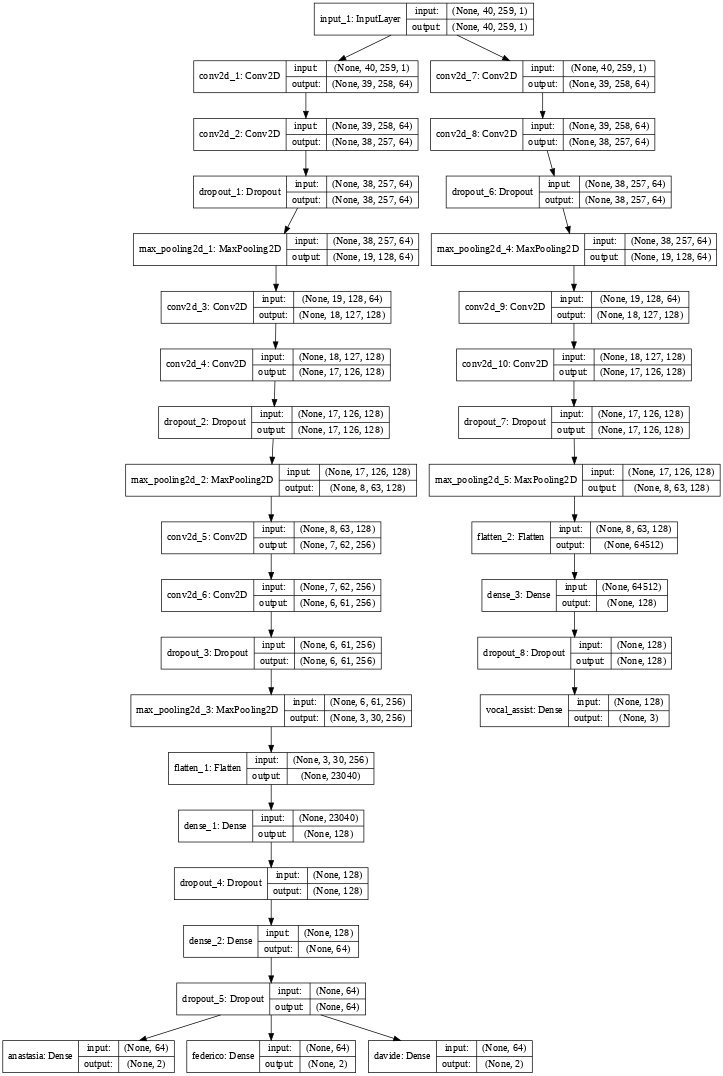

In [ ]:
plot_model(model,to_file='demo.png',show_shapes=True, dpi=50)

#### 4.4 Fitting del modello globale

Infine, si è addestrato il modello utilizzando 
- numero di epoche pari a 30 
- batch size pari a 32. 

In [ ]:
history = model.fit(X_train,[y_train_ana, y_train_fede, y_train_dav, y_train_va], 
                    validation_data=(X_test, [y_test_ana, y_test_fede, y_test_dav, y_test_va]), 
                    batch_size=32, epochs=30, verbose=1)

Train on 1440 samples, validate on 360 samples
Epoch 1/30
1440/1440 [==============================] - 14s 10ms/step - loss: 7.0418 - anastasia_loss: 0.5155 - federico_loss: 0.5883 - davide_loss: 0.6226 - vocal_assist_loss: 5.3154 - anastasia_accuracy: 0.8938 - federico_accuracy: 0.8257 - davide_accuracy: 0.7368 - vocal_assist_accuracy: 0.5444 - val_loss: 0.6621 - val_anastasia_loss: 0.0670 - val_federico_loss: 0.0958 - val_davide_loss: 0.1791 - val_vocal_assist_loss: 0.3192 - val_anastasia_accuracy: 0.9972 - val_federico_accuracy: 0.9917 - val_davide_accuracy: 0.9889 - val_vocal_assist_accuracy: 0.9250
Epoch 2/30
1440/1440 [==============================] - 13s 9ms/step - loss: 0.3611 - anastasia_loss: 0.0462 - federico_loss: 0.0824 - davide_loss: 0.1142 - vocal_assist_loss: 0.1183 - anastasia_accuracy: 0.9806 - federico_accuracy: 0.9688 - davide_accuracy: 0.9625 - vocal_assist_accuracy: 0.9611 - val_loss: 0.1771 - val_anastasia_loss: 0.0237 - val_federico_loss: 0.0279 - val_davide_lo

### 5. Risultati

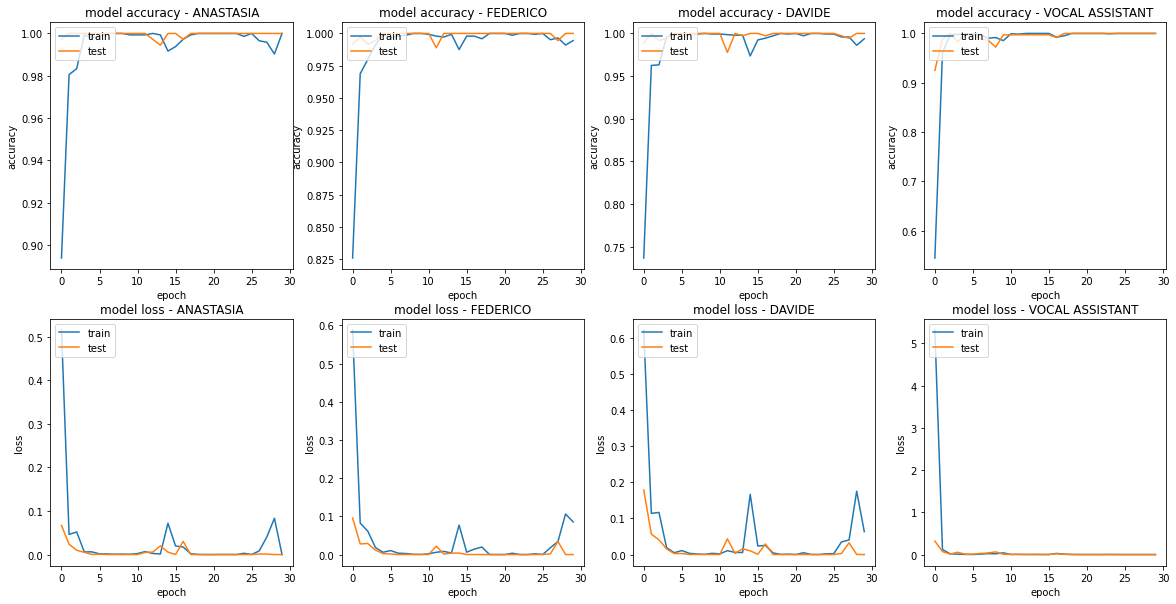

In [ ]:
plot_history(history)

In [ ]:
y_test_list = [y_test_ana, y_test_fede, y_test_dav, y_test_va]
names = ['Anastasia', 'Federico', 'Davide', 'Vocal Assistant']
pos = 0

y_pred = model.predict(X_test)
for y in y_test_list:
  print("\n -", names[pos])
  y_pred_ = np.argmax(y_pred[pos], axis = 1)
  y_test = np.argmax(y_test_list[pos], axis = 1)
  print(classification_report(y_test, y_pred_, digits = 2))
  pos+=1


 - Anastasia
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       1.00      1.00      1.00       129

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360


 - Federico
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00       117

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360


 - Davide
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       246
           1       1.00      1.00      1.00       114

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00   

In [ ]:
model.save(PATH+'model_processing1D')